In [1]:
import os
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
from glob import glob
import numpy as np
import matplotlib
import seaborn as sns
import PIL
PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import sys
import json
import pandas as pd
import cvlib as cv
from cvlib.object_detection import draw_bbox
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
import tensorflow_datasets as tfds

In [2]:
import pathlib

In [3]:
dataset_path = 'C:/Users/kangminju/Documents/DL_ws/원천_Training_통제환경분류'

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_x = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 100303 files belonging to 5 classes.
Using 80243 files for training.


In [6]:
val_x = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 100303 files belonging to 5 classes.
Using 20060 files for validation.


In [7]:
class_names = train_x.class_names
print(class_names)

['정상주시', '졸음재현', '통화재현', '하품재현', '흡연재현']


In [9]:
import platform
import seaborn as sns
from matplotlib import font_manager, rc

path = "C:/Windows/Fonts/malgun.ttf"

if platform.system() == "Darwin":
    rc("font", family = "Arial Unicode MS")
elif platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc("font", family=font_name)
else:
    print("Unknown system. sorry")

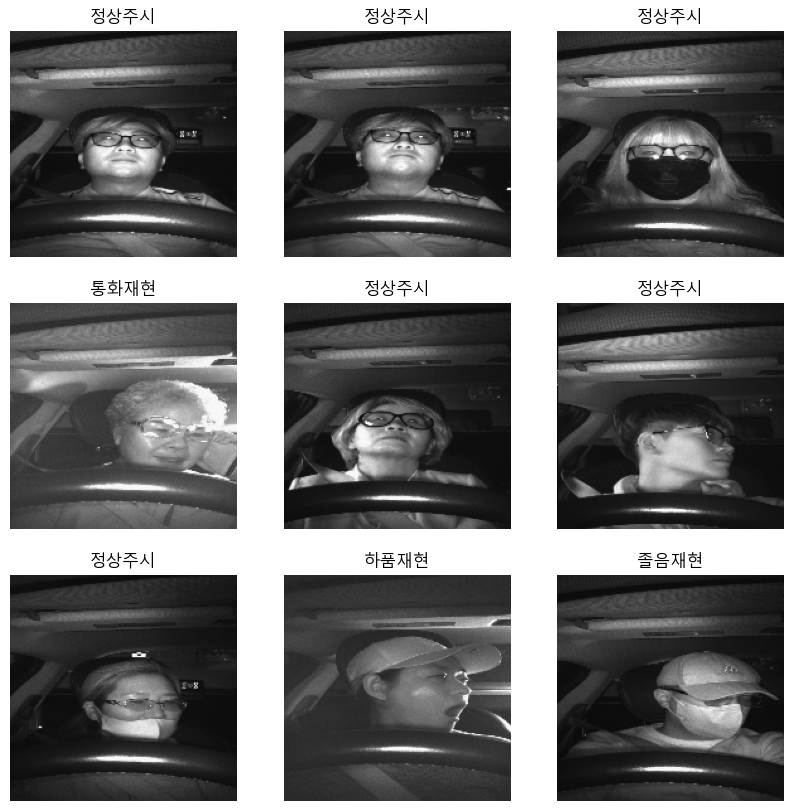

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_x.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_x:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [13]:
normalized_x = train_x.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_x))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0221173 0.9896513


## vggnet 사용

In [47]:
num_classes = 4

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax'),
  tf.keras.layers.Dense(num_classes)
])

In [45]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [46]:
hist = model.fit(
  train_x,
  validation_data=val_x,
  epochs=3
)

Epoch 1/3


ValueError: in user code:

    File "C:\Users\kangminju\miniconda3\envs\ds_study\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\kangminju\miniconda3\envs\ds_study\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\kangminju\miniconda3\envs\ds_study\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\kangminju\miniconda3\envs\ds_study\lib\site-packages\keras\engine\training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "C:\Users\kangminju\miniconda3\envs\ds_study\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\kangminju\miniconda3\envs\ds_study\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\kangminju\miniconda3\envs\ds_study\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\kangminju\miniconda3\envs\ds_study\lib\site-packages\keras\losses.py", line 1664, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\kangminju\miniconda3\envs\ds_study\lib\site-packages\keras\backend.py", line 4994, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 4) are incompatible


In [17]:
#### 검증 정확도가 훈련 정확도에 비해 낮으면 모델이 과대적합되었음을 알 수 있다.

In [18]:
hist.history

NameError: name 'hist' is not defined

NameError: name 'hist' is not defined

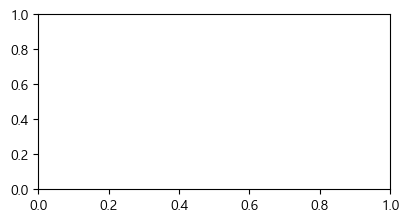

In [19]:
plt.figure(figsize=(10,5))
plt.subplot(221)
plt.plot(hist.history['loss'])
plt.title('loss')
plt.subplot(222)
plt.plot(hist.history['accuracy'])
plt.title('accuracy')
plt.subplot(223)
plt.plot(hist.history['val_loss'])
plt.title('val_loss')
plt.subplot(224)
plt.plot(hist.history['val_accuracy'])
plt.title('val_accuracy')

plt.tight_layout()
plt.show()

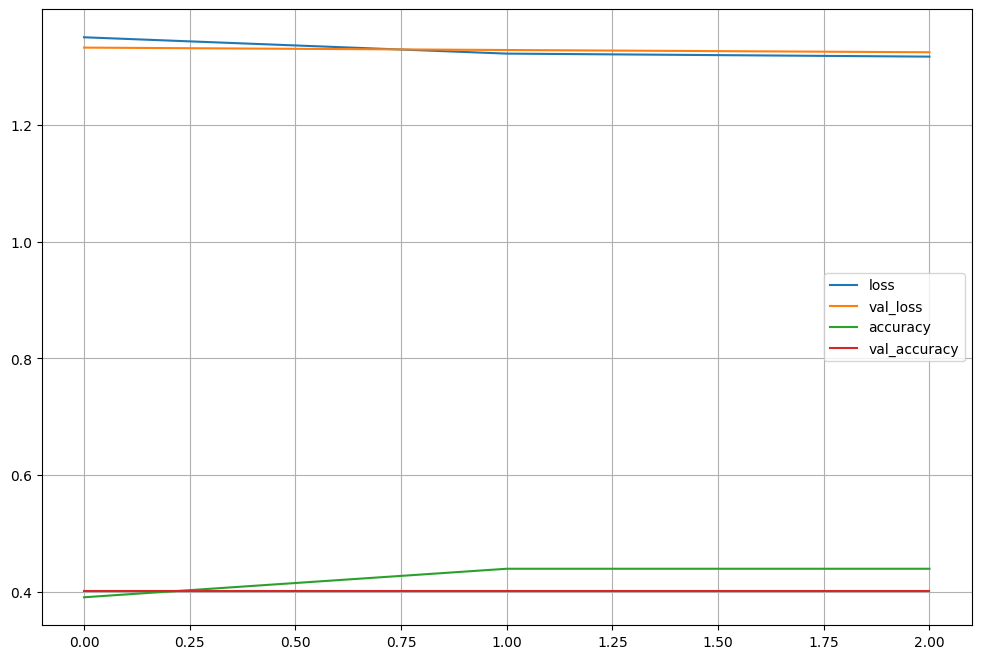

In [41]:
plot_target = ['loss', 'val_loss', 'accuracy', 'val_accuracy']

plt.figure(figsize=(12,8))

for each in plot_target:
    plt.plot(hist.history[each], label=each)

plt.legend()
plt.grid()
plt.show()

In [42]:
score = model.evaluate(train_x)
score

13/13 [==============================] - 6s 244ms/step - loss: 1.3139 - accuracy: 0.4396


[1.3138647079467773, 0.4395886957645416]

## resnet 사용

In [20]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Add

In [21]:
def build_resnet(input_shape):
    inputs = Input(input_shape)

    net = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(inputs)
    net = MaxPool2D()(net)

    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)

    net1_1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net = Add()([net1_1, net3])

    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)

    net = Add()([net, net3])

    net = MaxPool2D()(net)

    net = Flatten()(net)
    net = Dense(10, activation='softmax')(net)

    model2 = tf.keras.Model(inputs=inputs, outputs=net)

    return model2

In [22]:
model2 = build_resnet((180,180,3))

In [23]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 90, 90, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 45, 45, 32)  0           ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 45, 45, 64)   2112        ['max_pooling2d_2[0][0]']    

In [24]:
model2.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [25]:
hist2 = model2.fit(
  train_x,
  validation_data=val_x,
  epochs=3)

Epoch 1/3
2508/2508 [==============================] - 2045s 814ms/step - loss: 2.2304 - accuracy: 0.5263 - val_loss: 0.9933 - val_accuracy: 0.5868
Epoch 2/3
2508/2508 [==============================] - 2074s 827ms/step - loss: 0.9109 - accuracy: 0.6145 - val_loss: 0.8972 - val_accuracy: 0.6160
Epoch 3/3
2508/2508 [==============================] - 2038s 812ms/step - loss: 0.8445 - accuracy: 0.6411 - val_loss: 0.8428 - val_accuracy: 0.6518


In [26]:
hist2.history

{'loss': [2.230396270751953, 0.9108920693397522, 0.8445106744766235],
 'accuracy': [0.5263387560844421, 0.6144710183143616, 0.64110267162323],
 'val_loss': [0.9933277368545532, 0.8971771001815796, 0.8428375720977783],
 'val_accuracy': [0.586839497089386, 0.6159521341323853, 0.6518444418907166]}

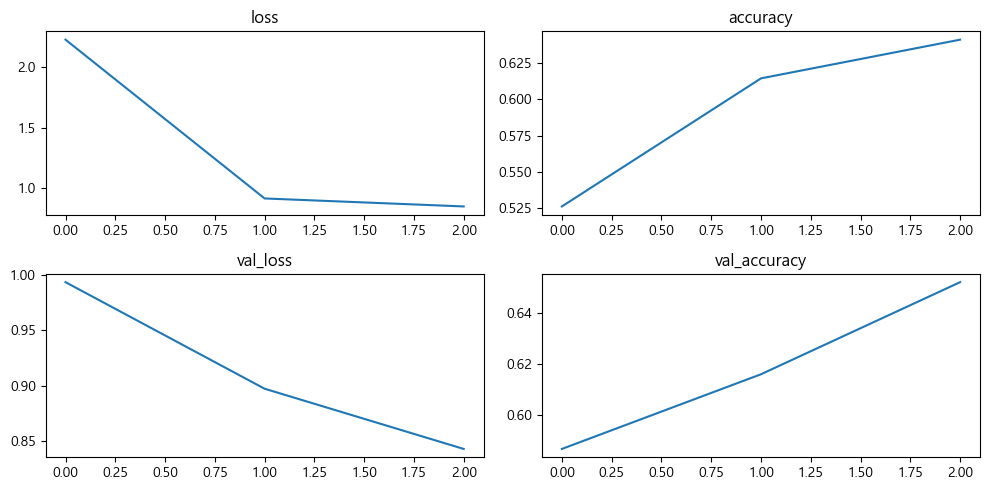

In [27]:
plt.figure(figsize=(10,5))
plt.subplot(221)
plt.plot(hist2.history['loss'])
plt.title('loss')
plt.subplot(222)
plt.plot(hist2.history['accuracy'])
plt.title('accuracy')
plt.subplot(223)
plt.plot(hist2.history['val_loss'])
plt.title('val_loss')
plt.subplot(224)
plt.plot(hist2.history['val_accuracy'])
plt.title('val_accuracy')

plt.tight_layout()
plt.show()

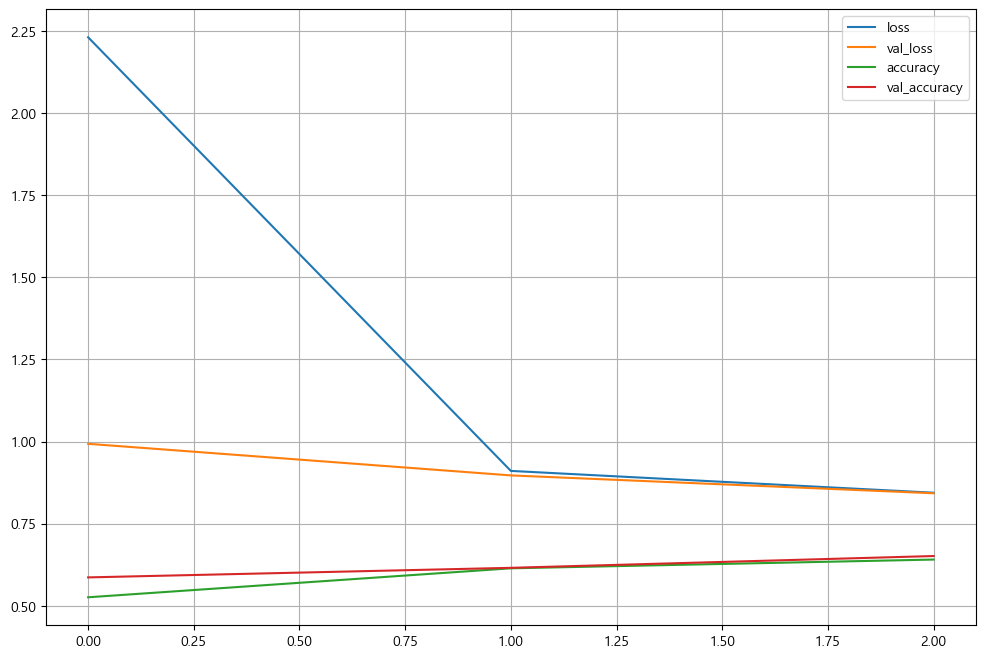

In [28]:
plot_target = ['loss', 'val_loss', 'accuracy', 'val_accuracy']

plt.figure(figsize=(12,8))

for each in plot_target:
    plt.plot(hist2.history[each], label=each)

plt.legend()
plt.grid()
plt.show()

In [29]:
score2 = model2.evaluate(val_x)
score2

627/627 [==============================] - 167s 265ms/step - loss: 0.8428 - accuracy: 0.6518


[0.8428367376327515, 0.6518444418907166]